This little project is a replication of the QuantEcon lecture: "39.Optimal growth model I: The stochastic optimal growth model"
and "40.Optimal growth model II: Accelerating the code with numba".

This code solves a discrete time infinte horizon consumption-savings problem with stochastic production.
The production is indeed:
$$ y_{t+1} = f(k_{t+1})\xi_{t+1} \tag{1}$$

where: $\xi_t$ are IID draws from a density function $\phi$

In particular, $\xi = exp(\mu+s\zeta)$ where $\zeta$ is standrd normal and $\mu$ and $s$ are respectively the shock location parameter and the shock scale parameter.

Therefore $\xi\sim$LogNormal$(\mu, s^2)$.


The problem to solve is: 

$$ \max_{c_t} \mathbb{E}\left[\sum_{t=0}^{\infty}\beta^t u(c_t)\right] \tag{2}$$
subject to:
$$ y_{t+1} = f(y_t - c_t)\xi_{t+1} \text{ and } 0<c_t<y_t \text{ for all t} $$

The Bellman equation for this problem is:
$$ v(y) = \max_{0\leq c \leq y}\left\{ u(c)+ \beta \int v(f(y-c)z)\phi dz\right\} \quad y\in \mathbb{R}_+ \tag{3}$$

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

Let's start by defining a method that maximizes a funxtion defined in an interval $[a,b]$

In [18]:
def maximize(g, a, b, args):
    '''
    Maximize a function g on the interval [a,b]
    
    This methods exploits the fact that the maximizer of a function g is
    also the minimizer of the function -g.
    
    Returns the maximizer and the max value
    '''
    
    obj_function = lambda x: -g(x, *args)                                     #negative function
    result = minimize_scalar(obj_function, bounds= (a, b), method ='bounded') #compute the maximizer and the minimum
    maximizer, maximum = result.x, -result.fun                                #get the maximizers and the maximum
    return maximizer, maximum

Now we can define a class for the Optimal Growth Model

In [19]:
class OptimalGrowthModel:
    
    def __init__(self, 
                u,
                f,
                beta = 0.96,
                mu = 0,
                s= 0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):
        
        self.u, self.f, self.beta, self.mu, self.s = u, f, beta, mu, s
        
        #setup grid
        self.grid = np.linspace(1e-4, grid_max, grid_size) 
        
        #store the shocks:
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shock_size))
        
    #RHS of the Bellman equation:
    def state_action_value(self, c, y, v_array):
        
        u, f, beta, shocks = self.u, self.f, self.beta, self.shocks
        
        v = interp1d(self.grid, v_array)  #linear interpolation
        
        return u(c) + beta * np.mean(v(f(y - c)*shocks))  #expectations are computed using Montecarlo method
                                                          #this method preserves the contraction mapping property
                                                          #of the Bellman operator.

The Bellman operator is defined as:
$$ Tv(y):=\max_{0\leq c\leq y}\left\{u(c)+\beta \int v(f(y-c)z)\phi dz \right\} \quad y\in \mathbb(R)_+ \tag{4}$$

The set of solution of the Bellman equation corresponds to the set of fixed points of $T$

If $Tv=v$, then for every $y\geq 0$:
$$ v(y)= Tv(y) = \max_{0\leq c\leq y}\left\{u(c)+\beta \int v^*(f(y-c)z)\phi dz \right\} $$

In [20]:
def T(v, og):
    '''
    Updates the guess of the value function and compute also
    a v-greddy policy (a v-greedy policy is a policy sigma(c)
    that is solution to the RHS of the Bellman equation)
    
    v is the array of guess of the value function
    og is an instance for OptimalGrowthModel
    '''
    
    v_new = np.empty_like(v)
    sigma = np.empty_like(v)
    
    for i in range(len(grid)):
        y = grid[i]
        
        #maximize the RHS of the Bellman equation at state y:
        c_star, v_max = maximize(og.state_action_value, 1e-10, y, (y, v))
        v_new[i] = v_max
        sigma[i] = c_star
        
    return sigma, v_new

Let's assume a functional form for $f$ and $u$:
$$ f(k)=k^{\alpha} $$
$$ u(c) = ln(c) $$

In [21]:
alpha = 0.4
def f(k):
    return k**alpha


def u(c):
    return np.log(c)

In [22]:
og = OptimalGrowthModel(u=u, f=f)

Now let's visualize how the Bellman operator works.

Initial guess of the value function: $ v(y) = 3\ln(y) $

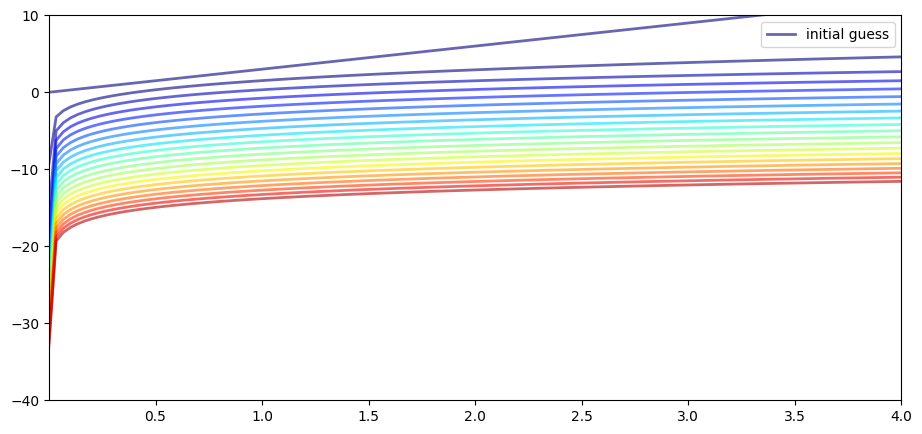

In [23]:
grid = og.grid

v = 3*(grid)    #initial guess of the value function

n = 20                   #number of iterations

fig, ax = plt.subplots()

ax.plot(grid, v, color=plt.cm.jet(0), lw=2, alpha=0.6, label = 'initial guess')

for i in range(n):
    sigma, v = T(v, og)
    ax.plot(grid, v, color=plt.cm.jet(i/n), lw=2, alpha=0.6)

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(grid), np.max(grid)))
plt.show()

We can solve the model by creating a function that iterates the value function with the Bellman operator until the difference $ Tv(y)-v(y) $ is close to $0$

In [24]:
def solve_model(og, 
               tol = 1e-4, 
               maxiter = 1000, 
               verbose = True, 
               print_skip = 50):
    
    #set up the loop:
    v = og.u(og.grid)   #initial condition
    i = 0
    error = tol + 1 
    
    while i < maxiter and error > tol:
        sigma, v_new = T(v, og) 
        error = np.max(np.abs(v - v_new))
        i +=1 
        if verbose and i % print_skip == 0:
            print(f'Error at iteration {i} is {error}')
        v = v_new
    
    if error > tol:
        print(f'Failed to converge')
    
    elif verbose:
        print(f'\n Coverged in {i} iterations')
    
    return sigma, v_new

In [25]:
sigma, v_solution = solve_model(og)

Error at iteration 50 is 0.1476753540823772
Error at iteration 100 is 0.01918093054865011
Error at iteration 150 is 0.0024913303848101975
Error at iteration 200 is 0.0003235884239707332

 Coverged in 229 iterations


Policy function:

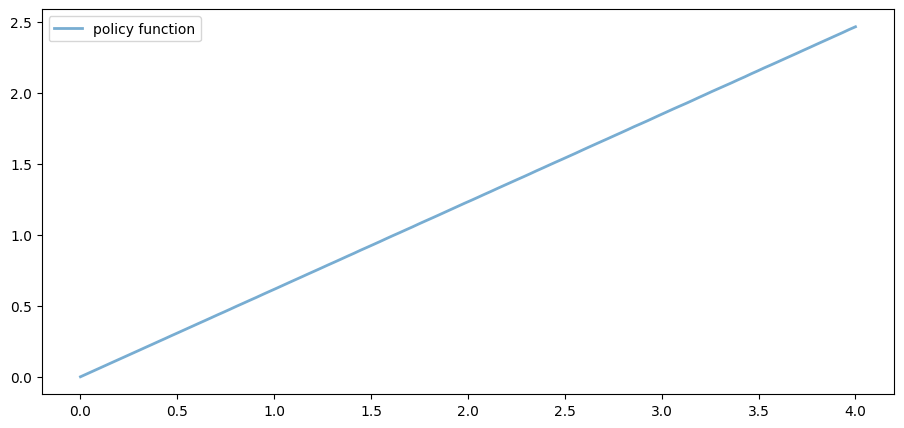

In [26]:
fig, ax = plt.subplots()

ax.plot(grid, sigma, lw=2,
        alpha=0.6, label='policy function')

ax.legend()
plt.show()

Let'see what happens with a CRRA utility function:
$$ u(c)=\frac{c^{1-\gamma}}{1-\gamma} $$

In [31]:
gamma = 1.5
def u_crra(c):
    return (c**(1-gamma))/(1-gamma)

In [32]:
og_crra = OptimalGrowthModel(u=u_crra, f=f)

In [33]:
%%time
sigma_crra, v_solution_crra = solve_model(og_crra)

Error at iteration 50 is 0.4590038713000695
Error at iteration 100 is 0.05961808205354657
Error at iteration 150 is 0.007743541895877115
Error at iteration 200 is 0.001005776083843557
Error at iteration 250 is 0.00013063602479235215

 Coverged in 257 iterations
CPU times: total: 1min 15s
Wall time: 1min 16s


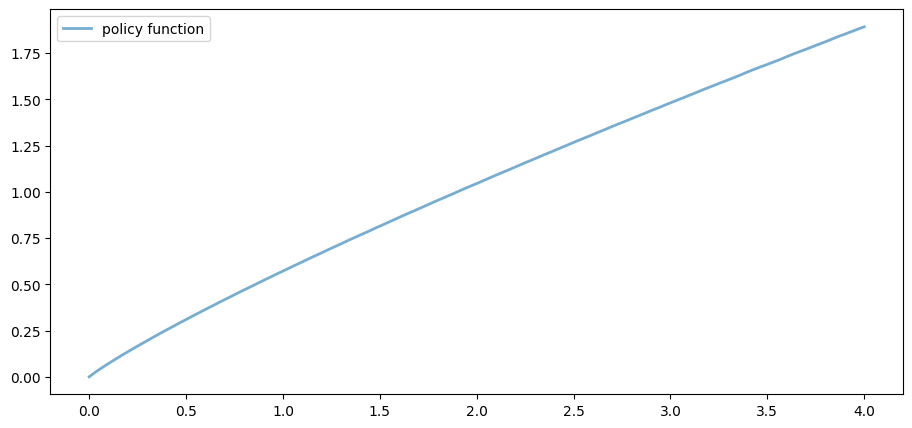

In [35]:
fig, ax = plt.subplots()

ax.plot(grid, sigma_crra, lw=2,
        alpha=0.6, label='policy function')

ax.legend()
plt.show()

In what follows we will speed up the code with just-in-time compilation.

In [36]:
from quantecon.optimize.scalar_maximization import  brent_max
from numba import jit
from numba.experimental import jitclass
from numba import float64

In [37]:
opt_growth_data = [
    ('alpha', float64),
    ('gamma', float64),
    ('beta', float64),
    ('mu', float64),
    ('s', float64),
    ('grid', float64[:]),
    ('shocks', float64[:])
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:
    
    def __init__(self,
                alpha=0.4,
                gamma=1.5,
                beta=0.96,
                mu=0,
                s=0.1,
                gridmax=4,
                gridsize=120,
                shocksize=250,
                seed=1234):
        
        self.alpha, self.gamma, self.beta, self.mu, self.s = alpha, gamma, beta, mu, s
        
        #grid
        self.grid = np.linspace(1e-4, gridmax, gridsize)
        
        #shocks
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shocksize))
        
    def f(self,k):
        return k**self.alpha
    
    def u(self,c):
        if self.gamma != 1:
            return (c**(1-self.gamma)) / (1-self.gamma)
        else:
            return np.log(c)

In [38]:
@jit
def state_action_value(c, y, v_array, og):
    '''
    Compute the RHS of the Bellman equation
    '''
    
    u, f, beta, shocks = og.u, og.f, og.beta, og.shocks
    
    v = lambda x : np.interp(x, og.grid, v_array)
    
    return u(c) + beta * np.mean(v(f(y-c)*shocks))

In [39]:
@jit
def T(v, og):
    
    v_new = np.empty_like(v)
    sigma = np.empty_like(v)
    
    #maximaize the Bellamn euqation for every state value y
    for i in range(len(og.grid)):
        y = og.grid[i]
        result = brent_max(state_action_value, 1e-10, y, args=(y, v, og))
        sigma[i], v_new[i] = result[0], result[1]
    
    return sigma, v_new

In [40]:
def solve_model(og,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=50):
    
    v = og.u(og.grid)    #initial condition
    i = 0
    error = tol + 1
    
    while i < max_iter and error > tol:
        sigma, v_new = T(v, og)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f'Error at iteration {i} is {error}.')
        v = v_new
    
    if error > tol:
        print('Failed to converge.')
    elif verbose:
        print(f'Converged in {i} iterations.')
    
    return sigma, v_new

In [41]:
og = OptimalGrowthModel()

In [42]:
%%time
sigma, v_solution = solve_model(og)

Error at iteration 50 is 0.4590038713004674.
Error at iteration 100 is 0.05961808205364605.
Error at iteration 150 is 0.007743541895933959.
Error at iteration 200 is 0.0010057760841846175.
Error at iteration 250 is 0.0001306360249913041.
Converged in 257 iterations.
CPU times: total: 8.38 s
Wall time: 8.38 s


Now we want to simulate a time series of wealth given an optimal policy funtion $\sigma(y)$.

The optimal wealth will follow this process:
$$ y_{t+1} = f(y_t - \sigma(y_t))\xi_{t+1} $$

We will simulate this time series for three different level of the discount factor: $\beta = 0.8,\quad 0.9,\quad 0.98$

The starting welath is $y_0 = 0.1$ and $s=0.05$

In [59]:
def simulate_output(sigma_func, og, y_0=0.1, timespan=100):
    y = np.zeros(timespan)
    shocks = np.random.randn(timespan-1)
    y[0] = y_0
    
    for i in range(timespan-1):
        y[i+1] = og.f(y[i]-sigma_func(y[i]))*np.exp(og.mu + og.s * shocks[i])
    
    return y

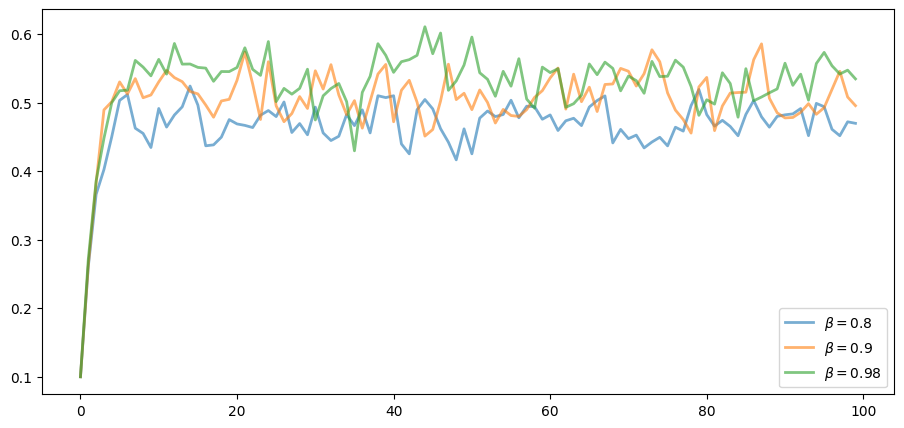

In [64]:
fig, ax = plt.subplots()

betas = [0.8, 0.9, 0.98]

s = 0.05

for beta in betas:
    
    og = OptimalGrowthModel(gamma=1, beta=beta, s=s)
    
    sigma, v_solution = solve_model(og, verbose=False)
    
    sigma_func = lambda x : np.interp(x, og.grid, sigma)
    
    y = simulate_output(sigma_func=sigma_func, og=og)
    
    ax.plot(y, lw=2, alpha=0.6, label=rf'$\beta = {beta}$')

ax.legend(loc='lower right')
plt.show()